This project features a conditional GANs model for images of Heat Transfer numerical simulation. 

The conditional label (binary) is constructed by a threshold *t* of row-wise variance. An image has label "1" if all row variances are less or equal *t*, "0" otherwise.

**Training set** - Set of images with:
*   Total images: 1009
*   Image size: 64 x 64 x 1 

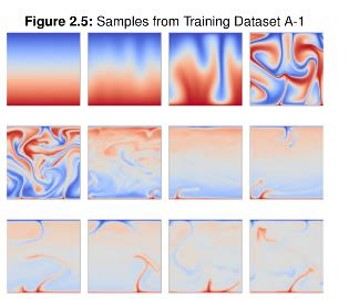

After training for 2,000 epochs, here are some generated images in respective labels.
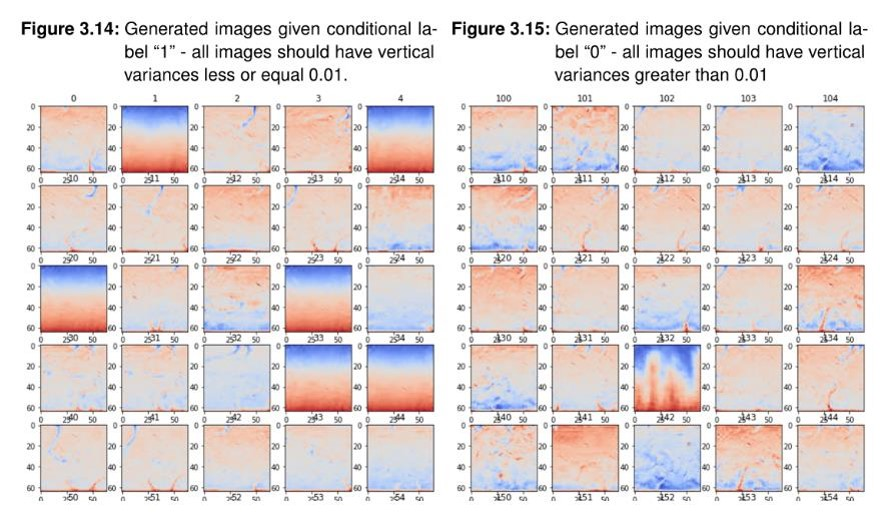



*References*

Jason Brownlee. [How to Develop an Information Maximizing GAN (InfoGAN) in Keras ](https://machinelearningmastery.com/how-to-develop-an-information-maximizing-generative-adversarial-network-infogan-in-keras/). Accessed: 2022-08-01. 2019.

Kuan Wei. [Build InfoGAN From Scratch.](https://towardsdatascience.com/build-infogan-from-scratch-f20ee85cba03). Accessed: 2022-08-01. 2020.

François Chollet. [DCGAN to generate face image](https://keras.io/examples/generative/dcgan_overriding_train_step/). Accessed: 2022-08-01. 2021.




In [ ]:
from google.colab import auth
auth.authenticate_user()

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import os
import gdown
from tqdm import tqdm
from PIL import Image

path_a1 = f'dataset_a1'
path_a2 = f'dataset_a2'
path_b1 = f'dataset_b1'

dataset = keras.preprocessing.image_dataset_from_directory(
    path_a1, label_mode=None, image_size=(64,64),
    batch_size=10,shuffle =True,color_mode="grayscale")
dataset = dataset.map(lambda x:  (x/255) *2 - 1)

In [ ]:
latent_dim = 62+1

def generator_model():
    model = tf.keras.Sequential()

    model.add(layers.Dense(4096, input_shape = [latent_dim]))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(layers.Reshape(target_shape=(2, 2, 1024)))
        
    model.add(layers.Conv2DTranspose(filters = 256, kernel_size = 4, padding = 'same'))
    model.add(layers.Activation('relu'))
    assert model.output_shape == (None, 2, 2, 256)

    model.add(layers.Conv2D(filters = 128, kernel_size = 4, padding = 'same'))
    model.add(layers.BatchNormalization(momentum = 0.7))
    model.add(layers.Activation('relu'))
    model.add(layers.UpSampling2D())
    assert model.output_shape == (None, 4, 4, 128)
    
    model.add(layers.Conv2D(filters = 64, kernel_size = 4, padding = 'same'))
    model.add(layers.BatchNormalization(momentum = 0.7))
    model.add(layers.Activation('relu'))
    model.add(layers.UpSampling2D())
    assert model.output_shape == (None, 8, 8, 64)
    
    model.add(layers.Conv2D(filters = 32, kernel_size = 4, padding = 'same'))
    model.add(layers.BatchNormalization(momentum = 0.7))
    model.add(layers.Activation('relu'))
    model.add(layers.UpSampling2D())
    assert model.output_shape == (None, 16, 16, 32)
    
    model.add(layers.Conv2D(filters = 16, kernel_size = 3, padding = 'same'))
    model.add(layers.BatchNormalization(momentum = 0.7))
    model.add(layers.Activation('relu'))
    model.add(layers.UpSampling2D())
    assert model.output_shape == (None, 32, 32, 16)
    
    model.add(layers.Conv2D(filters = 8, kernel_size = 3, padding = 'same'))
    model.add(layers.Activation('relu'))
    model.add(layers.UpSampling2D())
    assert model.output_shape == (None, 64, 64, 8)
    
    model.add(layers.Conv2D(filters = 2, kernel_size = 3, padding = 'same'))
    model.add(layers.Activation('tanh'))
    assert model.output_shape == (None, 64, 64, 2)
    
    return model
# declares the generator
generator = generator_model()
generator.summary()

def discriminator_model():
    image_input = keras.layers.Input(shape=[64, 64, 3])

    #add Gaussian noise to prevent Discriminator overfitting
    gau = layers.GaussianNoise(0.2, input_shape = [64, 64, 3])(image_input)

    c3 = layers.Conv2D(filters = 32, kernel_size = 3, padding = 'same')(gau)
    bnorm3 = layers.BatchNormalization(momentum = 0.7)(c3)
    act3 = layers.LeakyReLU(0.2)(bnorm3)
    drop3 = layers.Dropout(0.25)(act3)
    pool3 = layers.AveragePooling2D()(drop3)
    
    c4 = layers.Conv2D(filters = 64, kernel_size = 3, padding = 'same')(pool3)
    bnorm4 = layers.BatchNormalization(momentum = 0.7)(c4)
    act4 = layers.LeakyReLU(0.2)(bnorm4)
    drop4 = layers.Dropout(0.25)(act4)
    pool4 = layers.AveragePooling2D()(drop4)
    
    c5 = layers.Conv2D(filters = 128, kernel_size = 3, padding = 'same')(pool4)
    bnorm5 = layers.BatchNormalization(momentum = 0.7)(c5)
    act5 = layers.LeakyReLU(0.2)(bnorm5)
    drop5 = layers.Dropout(0.25)(act5)
    pool5 = layers.AveragePooling2D()(drop5)

    c6 = layers.Conv2D(filters = 256, kernel_size = 3, padding = 'same')(pool5)
    bnorm6 = layers.BatchNormalization(momentum = 0.7)(c6)
    act6 = layers.LeakyReLU(0.2)(bnorm6)
    drop6 = layers.Dropout(0.25)(act6)
    pool6 = layers.AveragePooling2D()(drop6)

    flat = layers.Flatten()(pool6)

    dense128 = layers.Dense(128)(flat)
    act7 = layers.LeakyReLU(0.2)(dense128)

    d_output = layers.Dense(1,activation='sigmoid')(act7)
    d_model = keras.models.Model(inputs=image_input, outputs=d_output)   
    
    return d_model
  
# Declares the discriminator
discriminator = discriminator_model()
discriminator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 4096)              262144    
                                                                 
 batch_normalization (BatchN  (None, 4096)             16384     
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 4096)              0         
                                                                 
 reshape (Reshape)           (None, 2, 2, 1024)        0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 2, 2, 256)        4194560   
 nspose)                                                         
                                                                 
 activation_1 (Activation)   (None, 2, 2, 256)         0

In [ ]:
class Adj_cGAN(keras.Model):
    def __init__(self, d_model, g_model, noise_size, num_classes):
        super(Adj_cGAN, self).__init__()
        self.d_model = d_model
        self.g_model = g_model
        self.noise_size = noise_size
        self.num_classes = num_classes 
        
    def compile(self, d_optimizer, g_optimizer):
        super(Adj_cGAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer      

    def get_channel_var(self,real_image_batch):
        '''returns a batch of variance-channels
        '''
        variance = tf.math.reduce_variance(real_image_batch,axis =2,keepdims=True)
        var_full = tf.repeat(variance, repeats = 64, axis = 2)
        return var_full # output shape (batch,64,64,1)
    
    def get_label(self,real_image_batch, threshold = 0.01):
        '''returns a batch of ground-truth labels
        '''
        batch = tf.shape(real_image_batch)[0]   
        var_full = self.get_channel_var(real_image_batch)
        r1 = tf.reduce_all(var_full<=threshold, axis = 1)
        r2 = tf.reduce_all(r1,axis = 1)
        r2 = tf.cast(r2,tf.float32)
        return r2 # output shape (batch,1)

    def get_channel_one_hot(self,real_image_batch):
        '''returns a batch of label-channels
        '''
        batch = tf.shape(real_image_batch)[0]   
        label = self.get_label(real_image_batch)
        one_hot = tf.repeat(label,repeats = 64*64)
        one_hot = tf.reshape(one_hot,[batch,64,64,1])
        return one_hot # output shape (batch,64,64,1)

    def train_step(self, real_image_batch):
        # Define loss functions
        binary_loss = keras.losses.BinaryCrossentropy(reduction="auto")
        # Half-batch for training discriminator
        batch = tf.shape(real_image_batch)[0]   
        
        # Prepare for Discriminator
        # Concatenate 3 channels of real batch
        real_image_channel_1 = self.get_channel_var(real_image_batch)
        real_image_channel_2 = self.get_channel_one_hot(real_image_batch)
        real_images_0_1_2 = keras.layers.Concatenate()([real_image_batch, 
                                                        real_image_channel_1, 
                                                        real_image_channel_2])
        # Generate a fake batch, borrow conditions from real batch
        noise = tf.random.normal([batch, self.noise_size], seed=None)
        label = self.get_label(real_image_batch, threshold = 0.01)
        g_input = keras.layers.Concatenate()([noise, label])
        fake_images_0_1 = self.g_model(g_input, training =True)
        fake_images_0_1_2 = keras.layers.Concatenate()([fake_images_0_1, 
                                                        real_image_channel_2])
        # Train Discriminator
        with tf.GradientTape() as d_tape: 
            self.d_model.trainable = True
            d_tape.watch(self.d_model.trainable_variables)
            d_real_output = self.d_model(real_images_0_1_2, training=True)
            d_loss_real = binary_loss(tf.ones((batch, 1)), d_real_output)          
            d_fake = self.d_model(fake_images_0_1_2, training=True)
            d_loss_fake = binary_loss(tf.zeros((batch, 1)), d_fake)
            d_loss =  d_loss_real + d_loss_fake
        # Calculate gradients
        d_gradients = d_tape.gradient(d_loss, self.d_model.trainable_variables)
        # Optimize
        self.d_optimizer.apply_gradients(zip(d_gradients, 
                                             self.d_model.trainable_variables))

        # Prepare for Generator
        noise = tf.random.normal([batch, self.noise_size], seed=None)
        label = self.get_label(real_image_batch, threshold = 0.01)
        g_input = keras.layers.Concatenate()([noise, label])
        # Train Generator
        with tf.GradientTape() as g_tape:
            self.g_model.trainable = True
            g_tape.watch(self.g_model.trainable_variables)
            # Create conditional fake image batch
            fake_images_0_1 = self.g_model(g_input, training =True)
            fake_images_0_1_2 = keras.layers.Concatenate()([fake_images_0_1, 
                                                        real_image_channel_2])
            d_fake = self.d_model(fake_images_0_1_2, training=True)
            g_img_loss = binary_loss(tf.ones((batch, 1)),d_fake)
            g_loss = g_img_loss 
            
        # Calculate gradients
        # We do not want to modify the neurons in the discriminator 
        # when training the generator 
        self.d_model.trainable=False
        g_gradients = g_tape.gradient(g_loss, self.g_model.trainable_variables)
        # Optimize
        self.g_optimizer.apply_gradients(zip(g_gradients, 
                                             self.g_model.trainable_variables))
           
        return {"d_loss": d_loss, "g_img_loss": g_img_loss}


# Create a new model instance
adj_cgan = Adj_cGAN(discriminator, generator, noise_size=62, 
                               num_classes=1)
adj_cgan.compile(d_optimizer=keras.optimizers.Adam(learning_rate=2e-4),
                g_optimizer=keras.optimizers.Adam(learning_rate=5e-4))


In [ ]:
## Restore the weights
adj_cgan.load_weights('save_path')

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath='save_path', 
                                                 save_freq = 101*50,
                                                 save_weights_only=True)

# Resume training
first = 0
last = 1
adj_cgan.fit(dataset, epochs=last, initial_epoch = first, 
              callbacks=[cp_callback])

In [ ]:
# Result 2: Load adjusted cGAN model's weights - t1=0.01
adj_cgan.load_weights('save_path')

In [ ]:
# Prepare inputs for G
batch = 200 
halfbatch = 100 
c_batch = tf.concat([tf.ones([halfbatch]),tf.zeros([halfbatch])],axis = 0) 
c_batch = tf.reshape(c_batch,[batch,1])
z_batch = tf.random.normal([batch, adj_cgan.noise_size], seed=None)
zc = keras.layers.Concatenate()([z_batch, c_batch])

# Generate fake images (2-channel)
fake_images_0_1 = adj_cgan.g_model(zc, training =False)

# Extract first channel
FAKE = np.array(fake_images_0_1)[:,:,:,0].reshape((batch,64,64))

# Compute maximum variances
VAR = np.var(FAKE,axis = 2).reshape((batch,64))

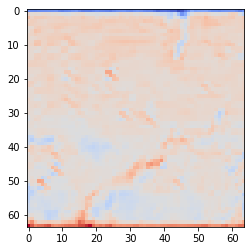

In [ ]:
plt.imshow(FAKE[0], cmap = 'coolwarm_r')